In [2]:
import numpy as np
import scipy.io
from grid import grid
import torchkbnufft as tkbn
import torch
import utils_dist
import matplotlib.pyplot as plt

k_radial = scipy.io.loadmat('radial_data.mat')['k']

'''
nRO: the number of readout points
nSpocks: the number of kdata trajectories.
'''
nRO, nSpokes = k_radial.shape
print(k_radial.shape)

(384, 600)


# 1. Radial Sampling pattern

(384, 1)
0.010908202668886702 6.2745803238948525 (600,)
(384, 600)


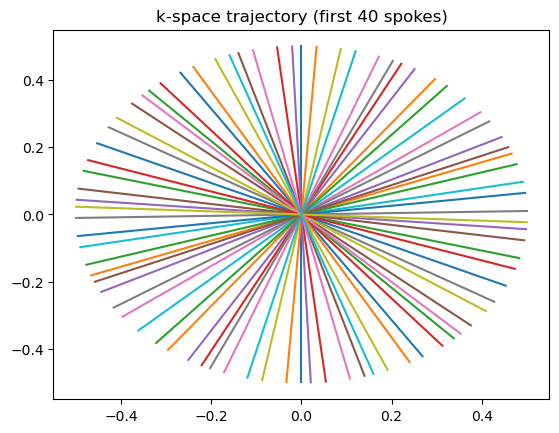

In [3]:
PI = np.pi
GA = 111.246117975 * (PI/180)
'Normalize spoke length from -.5 to .5 cause of gridding func'
r = np.linspace(-0.5, 0.5, nRO).reshape((nRO,1))  # K-space trajectory
print(r.shape)

theta = np.mod(np.arange(PI/2, nSpokes * GA, GA), 2*PI)
print(theta.min(), theta.max(), theta.shape)

traj = r * np.exp(1j*theta)
print(traj.shape)

ns = 40
plt.plot(traj[:,:ns].real, traj[:,:ns].imag)
plt.title('k-space trajectory (first 40 spokes)')
plt.savefig('trajectory.png')
plt.show()


# ....... Do the spokes match Nyquist rate? ........

# 2. Basic gridding reconstruction

(384, 384)


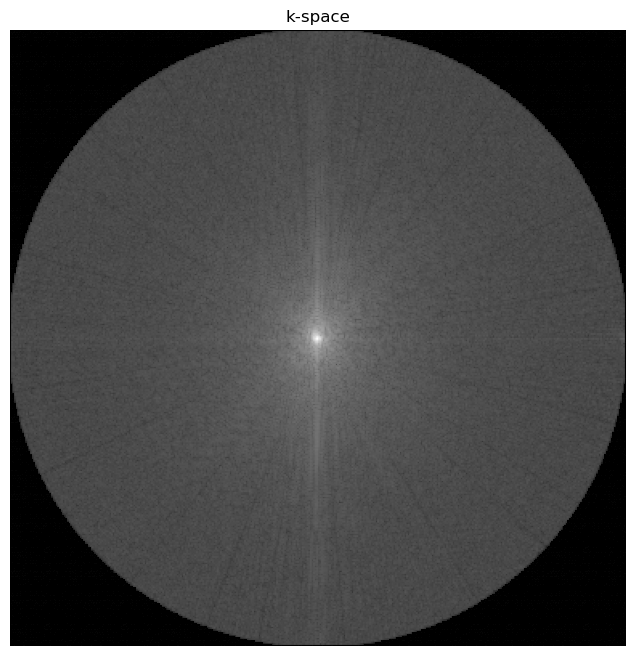

In [4]:
k_cartesian = grid(k_radial, k=traj, n=nRO)
print(k_cartesian.shape)

k_cart_recon = utils_dist.ifft2c(k_cartesian)
utils_dist.imshow1row([k_cartesian], ["k-space"],  isMag=True, norm=0.1)
utils_dist.imshow1row([abs(k_cart_recon)], ["Image"],filename='2_recon.png',isMag=False) # But blurry cause of additional projections acquired over full rotation
utils_dist.imshow1row([k_radial, k_cartesian],["Radial","Cartesian"],filename='2_kspace.png', isMag=True, norm=0.1)

# 3. Compensate density using ramp

In [5]:
def get_ramp(k_radial):
    nRO , nSpocks = k_radial.shape
    ramp = np.abs(np.linspace(-1 + 1/nSpocks, 1-1/nSpocks, nRO))[:, None] + 1/nSpocks
    return ramp

ramp = get_ramp(k_radial)
k_radial_ramp = ramp * k_radial
k_cart_ramp = grid(k_radial_ramp, traj, nRO)
k_cart_ramp_recon = utils_dist.ifft2c(k_cart_ramp)
utils_dist.imshow1row([abs(k_cart_ramp_recon), abs(k_cart_recon)],['Ramp filtered', 'Original'],filename='3_recon.png',isMag=False)

 # 4. Oversampling

In [13]:
os_rate = (1.5, 2)
k_cart_ramp_os_1 = grid(k_radial_ramp, traj, int(nRO*os_rate[0]))
k_cart_ramp_os_2 = grid(k_radial_ramp, traj, int(nRO*os_rate[1]))
k_cart_ramp_os_recon1 = utils_dist.ifft2c(k_cart_ramp_os_1)
k_cart_ramp_os_recon2 = utils_dist.ifft2c(k_cart_ramp_os_2)
k_cart_ramp_os_recon_cropped1 = utils_dist.crop(k_cart_ramp_os_recon1, int(np.multiply(nRO,os_rate[0])), os_rate[0])
k_cart_ramp_os_recon_cropped2 = utils_dist.crop(k_cart_ramp_os_recon2, int(np.multiply(nRO,os_rate[1])), os_rate[1]) 

utils_dist.imshow1row([abs(k_cart_ramp_os_recon_cropped2),abs(k_cart_ramp_os_recon_cropped1),abs(k_cart_ramp_recon)],['over sampled(2x)','over sampled(1.5x)','Ramp filtered'],filename='4_recon_3.png',isMag=False)


# 5. Deapodize (divide same kernel) as siganls pf intensity higher in center due to regridding kernel shape

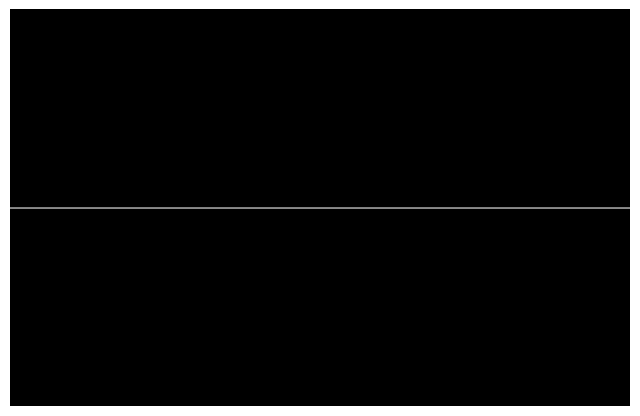

In [93]:
delta = np.zeros_like(k_radial)
delta[nRO//2, :] = 1
utils_dist.imshow1row([delta])

In [94]:
tri_k = grid(delta, traj, nRO*os_rate[0])
c = utils_dist.ifft2c(tri_k)
a = 1
utils_dist.imshow1row([c],['De-apodization function'],filename='5_func.png', isMag=True)

In [95]:
k_cart_ramp_os_deapo_recon = k_cart_ramp_os_recon1/(c + a)
k_cart_ramp_os_deapo_recon_cropped = utils_dist.crop(k_cart_ramp_os_deapo_recon,nRO*os_rate[0], os_rate[0])
utils_dist.imshow1row([abs(k_cart_ramp_os_deapo_recon_cropped),abs(k_cart_ramp_os_recon_cropped2),abs(k_cart_ramp_recon), abs(k_cart_recon)],['deapodized','over sampled(2x)','Ramp filtered', 'Original'],filename='5_recon.png',isMag=False)

# 6.NUFFT (compare for all data, os case as well. No artifacts should be present at all after this in report)

In [96]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [97]:
r = np.linspace(-PI, PI, nRO)[:, None]
theta = np.mod(np.arange(PI/2, nSpokes * GA, GA), 2*PI)
traj_nufft = r * np.exp(1j*theta)
ktraj = np.vstack((traj_nufft.real.flatten(),traj_nufft.imag.flatten()))
print(ktraj.shape)

(2, 230400)


In [99]:
ktraj = torch.tensor(ktraj, device=device)
kdata = torch.tensor(k_radial.flatten()[None, None,:]).to(device)
kdata_ramp = torch.tensor(k_radial_ramp.flatten()[None, None,:]).to(device)
im_size = (nRO, nRO)
adjnufft = tkbn.KbNufftAdjoint(im_size=im_size, grid_size=(int(nRO*1.5), int(nRO*1.5)),table_oversamp=3).to(device)
print(adjnufft)
nufft_recon = adjnufft(kdata, ktraj)
nufft_ramp_recon = adjnufft(kdata_ramp, ktraj)


KbNufftAdjoint
----------------------------------------
buffers
	tensor: table_0, shape: (19,)
	tensor: table_1, shape: (19,)
	tensor: im_size, shape: (2,)
	tensor: grid_size, shape: (2,)
	tensor: n_shift, shape: (2,)
	tensor: numpoints, shape: (2,)
	tensor: offsets, shape: (36, 2)
	tensor: table_oversamp, shape: (2,)
	tensor: order, shape: (2,)
	tensor: alpha, shape: (2,)
	tensor: scaling_coef, shape: (384, 384)



In [100]:
nufft_recon = nufft_recon.cpu().numpy()[0,0]
nufft_ramp_recon = nufft_ramp_recon.cpu().numpy()[0,0]
utils_dist.imshow1row([abs(nufft_ramp_recon), abs(k_cart_ramp_os_deapo_recon_cropped)],['Kaiser-Bessel(os=1.5x)','Triangular(os=1.5x)'],filename='6_recon_1.png',isMag=False)

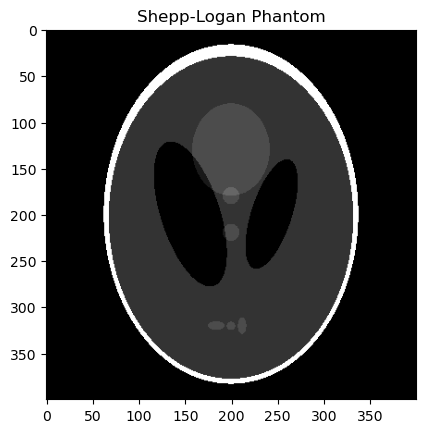

In [83]:
from skimage.data import shepp_logan_phantom
# create a simple shepp logan phantom and plot it
image = shepp_logan_phantom().astype(complex)
im_size = image.shape
plt.imshow(np.absolute(image))
plt.gray()
plt.title('Shepp-Logan Phantom')
plt.show()

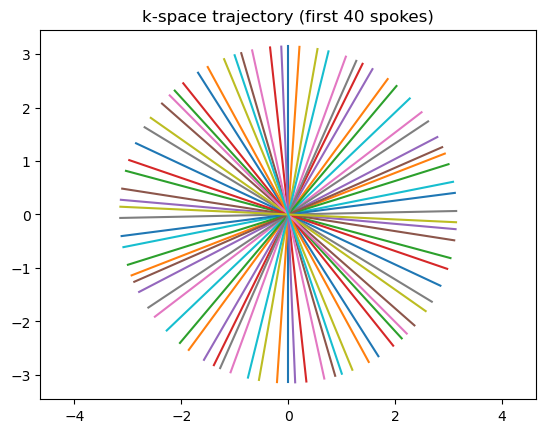

(405, 400)


In [84]:
# create a k-space trajectory and plot it
spokelength = int(image.shape[-1] * 1)
grid_size = (spokelength, spokelength)
nspokes = 405

ga = np.deg2rad(180 / ((1 + np.sqrt(5)) / 2))
kx = np.zeros(shape=(spokelength, nspokes))
ky = np.zeros(shape=(spokelength, nspokes))
ky[:, 0] = np.linspace(-np.pi, np.pi, spokelength)
for i in range(1, nspokes):
    kx[:, i] = np.cos(ga) * kx[:, i - 1] - np.sin(ga) * ky[:, i - 1]
    ky[:, i] = np.sin(ga) * kx[:, i - 1] + np.cos(ga) * ky[:, i - 1]
    
ky = np.transpose(ky)
kx = np.transpose(kx)

ktraj = np.stack((ky.flatten(), kx.flatten()), axis=0)

# plot the first 40 spokes
plt.plot(kx[:40, :].transpose(), ky[:40, :].transpose())
plt.axis('equal')
plt.title('k-space trajectory (first 40 spokes)')
plt.show()
print(kx.shape)

In [85]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# convert k-space trajectory to a tensor
ktraj = torch.tensor(ktraj).to(device)
print('ktraj shape: {}'.format(ktraj.shape))

# convert the phantom to a tensor and unsqueeze coil and batch dimension
image = torch.tensor(image).to(device).unsqueeze(0).unsqueeze(0)
print('image shape: {}'.format(image.shape))


# create NUFFT objects, use 'ortho' for orthogonal FFTs
nufft_ob = tkbn.KbNufft(
    im_size=im_size,
    grid_size=grid_size,
    table_oversamp=2
).to(image)
adjnufft_ob = tkbn.KbNufftAdjoint(
    im_size=im_size,
    grid_size=grid_size,
    table_oversamp=2
).to(image)

print(nufft_ob)
print(adjnufft_ob)
# calculate k-space data
kdata = nufft_ob(image, ktraj)
# add some noise (robustness test)
siglevel = torch.abs(kdata).mean()
kdata = kdata + (siglevel/5) * torch.randn(kdata.shape).to(kdata)
print(kdata.shape)

ktraj shape: torch.Size([2, 162000])
image shape: torch.Size([1, 1, 400, 400])

KbNufft
----------------------------------------
buffers
	tensor: table_0, shape: (13,)
	tensor: table_1, shape: (13,)
	tensor: im_size, shape: (2,)
	tensor: grid_size, shape: (2,)
	tensor: n_shift, shape: (2,)
	tensor: numpoints, shape: (2,)
	tensor: offsets, shape: (36, 2)
	tensor: table_oversamp, shape: (2,)
	tensor: order, shape: (2,)
	tensor: alpha, shape: (2,)
	tensor: scaling_coef, shape: (400, 400)


KbNufftAdjoint
----------------------------------------
buffers
	tensor: table_0, shape: (13,)
	tensor: table_1, shape: (13,)
	tensor: im_size, shape: (2,)
	tensor: grid_size, shape: (2,)
	tensor: n_shift, shape: (2,)
	tensor: numpoints, shape: (2,)
	tensor: offsets, shape: (36, 2)
	tensor: table_oversamp, shape: (2,)
	tensor: order, shape: (2,)
	tensor: alpha, shape: (2,)
	tensor: scaling_coef, shape: (400, 400)

torch.Size([1, 1, 162000])


In [86]:
# adjnufft back
# method 1: no density compensation (blurry image)
image_blurry = adjnufft_ob(kdata, ktraj)

# method 2: use density compensation
dcomp = tkbn.calc_density_compensation_function(ktraj=ktraj, im_size=im_size)
image_sharp = adjnufft_ob(kdata * dcomp, ktraj)

C:\Users\navne\anaconda3\lib\site-packages\torchkbnufft\_nufft\interp.py:651: UserWarning: __rfloordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  if num_threads // factor <= data.shape[0] * data.shape[1]:


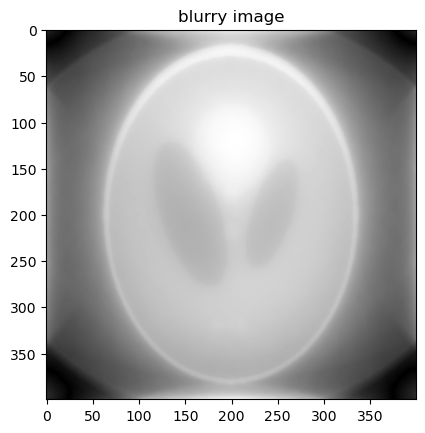

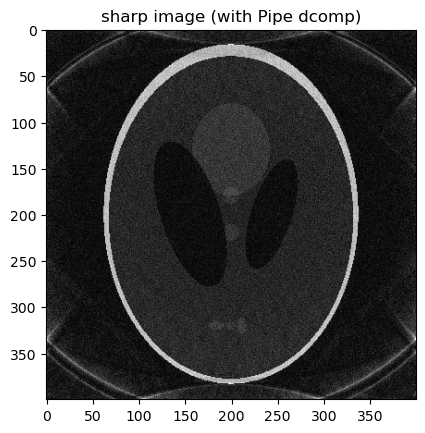

In [87]:
# show the images
image_blurry_numpy = np.squeeze(image_blurry.cpu().numpy())

image_sharp_numpy = np.squeeze(image_sharp.cpu().numpy())

plt.figure(0)
plt.imshow(np.absolute(image_blurry_numpy))
plt.gray()
plt.title('blurry image')

plt.figure(1)
plt.imshow(np.absolute(image_sharp_numpy))
plt.gray()
plt.title('sharp image (with Pipe dcomp)')

plt.show()